In [45]:
import os 
os.chdir('..')

In [46]:
print(os.getcwd())

/home/pdavid/Bureau/Code/SS


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg

import importlib
importlib.reload(post)

plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (12,12)

In [48]:
import sys
importlib.reload(sys.modules['module_2D_coupling'])
from module_2D_coupling import * 

Properties of the sources and the problem

In [49]:
#0-Set up the sources
Rv=0.01
C0=1
K_eff=1/(np.pi*Rv**2)
pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[4.0,3.9]])-np.array([0.25,0.25])
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6]])-np.array([0.25,0.25])
#1-Set up the domain
D=1
L=6
h_ss=1
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(L//h_ss))
y_ss=x_ss

We obtain the full problem of the concentration field:
\begin{cases}
\Delta \phi(\mathbf{x}) = \sum_{j \in \Omega} q_j \delta_j(\mathbf{x},\mathbf{x}_j) \quad  in \quad \Omega\\
\\
  \phi(\mathbf{x})= 0 \quad  on \quad \partial \Omega \\
\end{cases}  
<br>
<br>
and,
<br>
$$q_j=K_{eff} \pi Rv_j^2 (\langle \phi_j \rangle - \bar{\phi}_j)$$
<br>
$$\bar{\phi}_j=\phi({x}_j)$$

For the assembly of the problem:  <br>
$\quad$ - First, we use the assembly of the laplacian that has been validated <br>
$\quad$ - Second, we translate the Dirichlet boundary conditions to Neuman

In [50]:
A=A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
#set dirichlet
B,A=set_TPFA_Dirichlet(0,A, h_ss, get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)

To model the sources interaction with the tissue we use the solution splitting technique:
Assemble of the problem
$$
M=
\begin{bmatrix}
[A] & [B] & [C]\\
[D] & [E] & [F]\\
[G] & [H] & [I]
\end{bmatrix} 
$$

For the steady state problem:
$$
M * \begin{Bmatrix}\phi \\ {v} \\ q\end{Bmatrix}= \begin{Bmatrix}0 \\ {0} \\ \langle \phi \rangle\end{Bmatrix}
$$

In [51]:
#Assemble of the solution split problem 
t=assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D) #__init__ function
t.pos_arrays() #gets all the connectivity arrays that are necessary
t.assembly_sol_split_problem() #assembles all the submatrices and joins them into a big one

[3.25 3.55]
[3.15 3.15]
[3.85 3.35]
[3.75 3.65]


array([[-10.        ,   1.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.        ,  -7.        ,   1.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   1.        ,  -7.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   1.        ,
         -0.68241359,  -0.69360075],
       [  0.        ,   0.        ,   0.        , ...,  -0.68241359,
          1.        ,  -0.5497017 ],
       [  0.        ,   0.        ,   0.        , ...,  -0.69360075,
         -0.5497017 ,   1.        ]])

In [52]:
np.where(np.unique(t.s_blocks)==21)[0][0]


0

In [53]:
#initial right hand side
B_v=np.zeros(len(np.unique(t.s_blocks))*9)
B_q=np.ones(len(t.s_blocks))
#B_q[-2]=-1
B=np.concatenate((B,B_v,B_q))

phi=np.linalg.solve(t.M, B)


In [54]:
phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

In [55]:
o=post.reconst_microscopic(t, phi)    
rec=o.reconstruct(20,L)

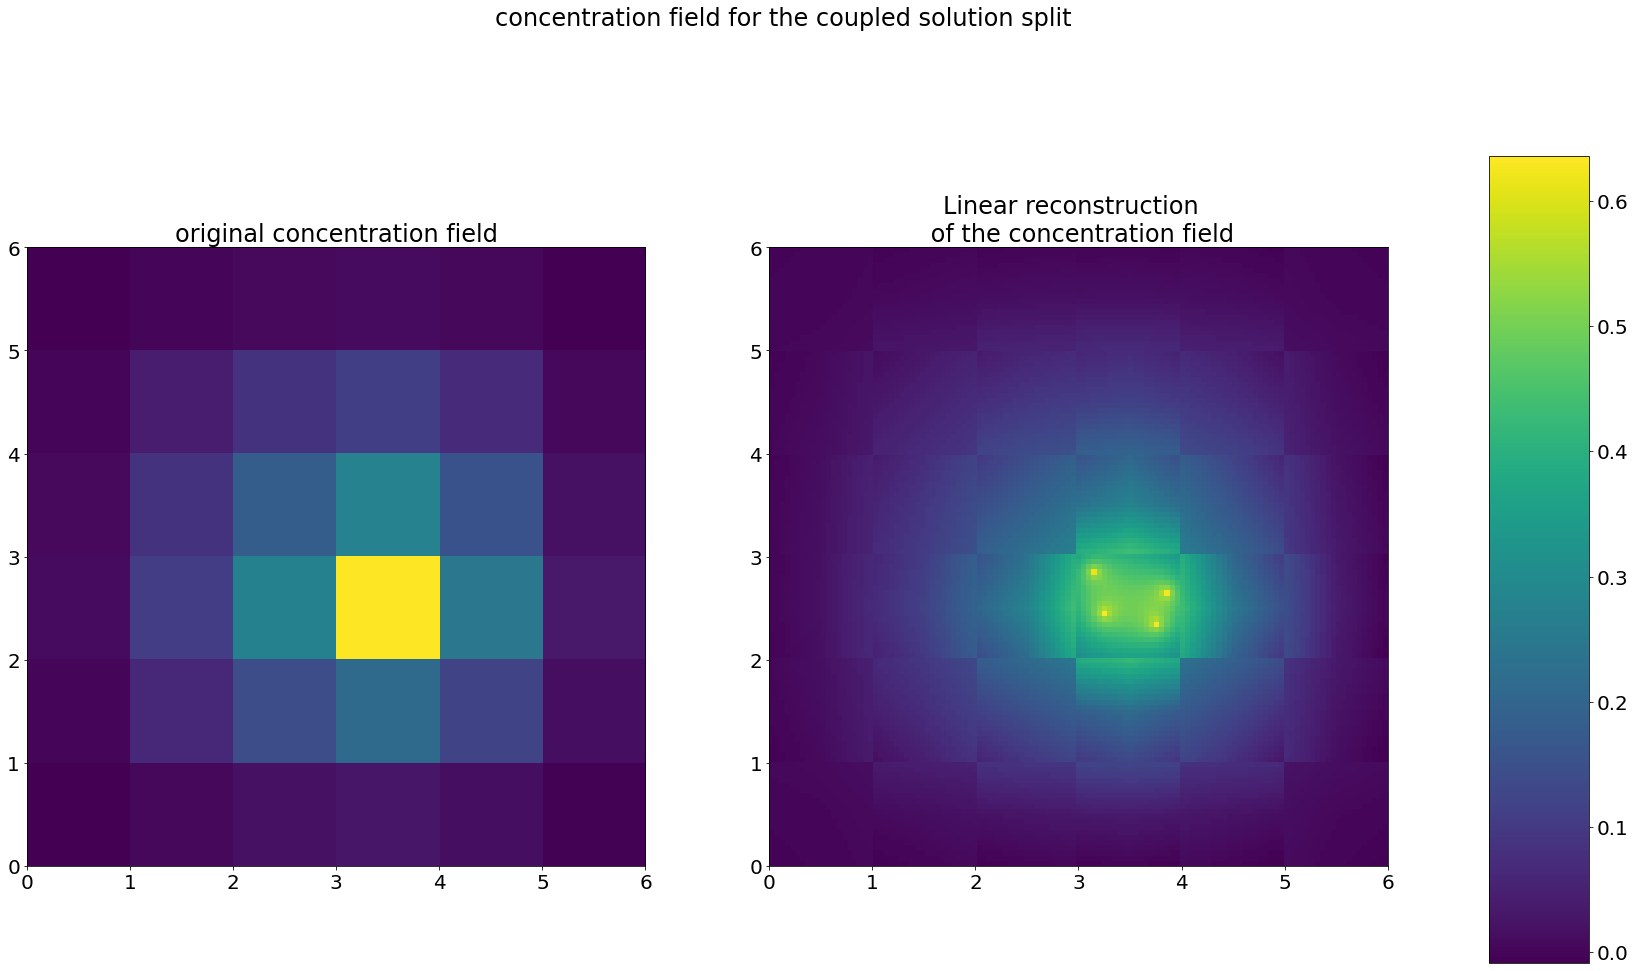

In [56]:
fig, axs=plt.subplots(1,2, figsize=(28,16))
fig.suptitle("concentration field for the coupled solution split")
im=axs[0].imshow(phi_FV.reshape(len(y_ss), len(x_ss)), extent=[0,L,0,L])
axs[0].set_title("original concentration field")
im=axs[1].imshow(rec, extent=[0,L,0,L])
axs[1].set_title("Linear reconstruction  \n of the concentration field")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [57]:
sol_val, xlen2, ylen2,q_array,a, Y, s_b,x_v,y_v=get_validation(20, t, pos_s, B_q, D, K_eff, Rv,L)


In [58]:
val_mat=sol_val.reshape(ylen2, xlen2)

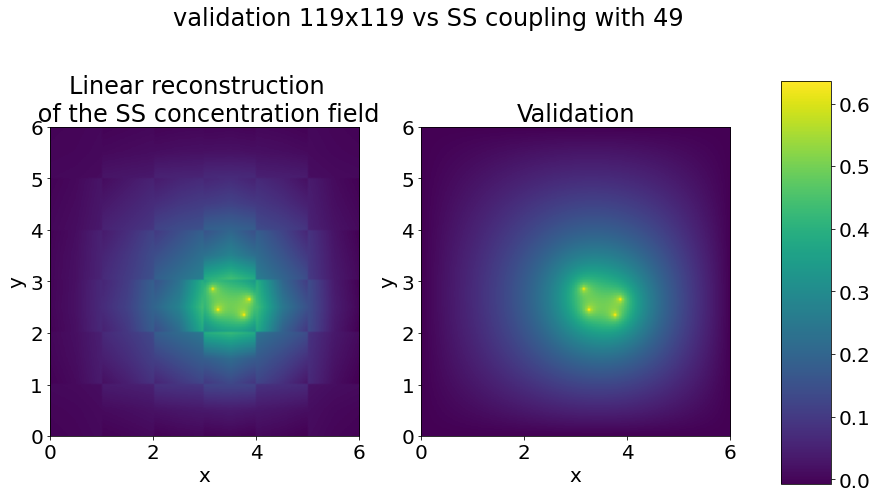

In [75]:
fig, axs=plt.subplots(1,2, figsize=(14,8))
title="validation {}x{} vs SS coupling with {}".format(xlen2, ylen2, t.M.shape[0])
fig.suptitle(title)
im=axs[1].imshow(sol_val.reshape(ylen2, xlen2), extent=[0,L,0,L])
axs[1].set_title("Validation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
im=axs[0].imshow(rec, extent=[0,L,0,L])
axs[0].set_title("Linear reconstruction  \n of the SS concentration field")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

Get the comparison plots 

Test the efficiency of the scheme

In [60]:
q_comp=np.zeros((0,len(q_array)))
solutions=[]
lx=np.array([])
x_c=[]
y_c=[]

for i in np.arange(4)+1:
    sol, xlen3, ylen3,q_array,a, Y, s_b,p,pp=get_validation(i**2, t, pos_s, B_q, D, K_eff, Rv,L)
    q_comp=np.concatenate((q_comp, np.array([q_array])), axis=0)
    solutions.append(sol)
    lx=np.append(lx, xlen2)
    x_c.append(p)
    y_c.append(pp)

In [61]:
x_c[0]

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

In [62]:
def get_plots_comp(pos_s, solution, rec, o, y_c,x_c, validation, y_v, x_v):
    solution=solution.reshape(len(y_c),len(x_c))
    val_mat=validation.reshape(len(y_v), len(x_v))
    row_rec=np.array([], dtype=int)
    for i in pos_s:
        row=np.argmin(np.abs(i[1]-o.y))
        row_rec=np.append(row_rec, row)
    print(row_rec)
    row_c=np.array([], dtype=int)
    for i in pos_s:
        row=np.argmin(np.abs(i[1]-y_c))
        row_c=np.append(row_c, row)
    row_v=np.array([], dtype=int)
    for i in pos_s:
        row=np.argmin(np.abs(i[1]-y_v))
        row_v=np.append(row_v, row)
    fig, axs=plt.subplots(2,2, figsize=(14,14))
    fig.suptitle("comparison SS vs {}x{} FV".format(len(y_c), len(x_c)))
    for i in range(2):
        for j in range(2):
            a=int(j+2*i)
            axs[i,j].plot(x_c, solution[row_c[a],:], label="FV")
            axs[i,j].plot(o.x, rec[row_rec[a],:], label="SS reconstructed")
            axs[i,j].plot(x_v, val_mat[row_v[a],:], label="validation") 
            axs[i,j].set_title("source={}".format(a))
            axs[i,j].legend(loc="lower center")
    plt.show()


[70 62 66 72]


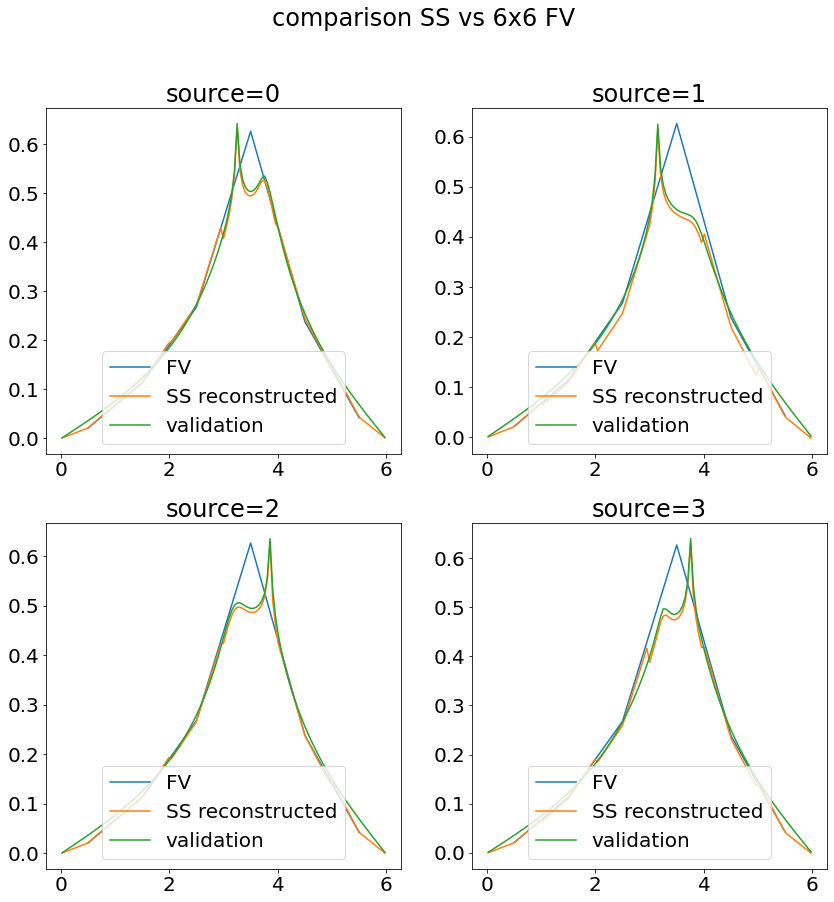

[70 62 66 72]


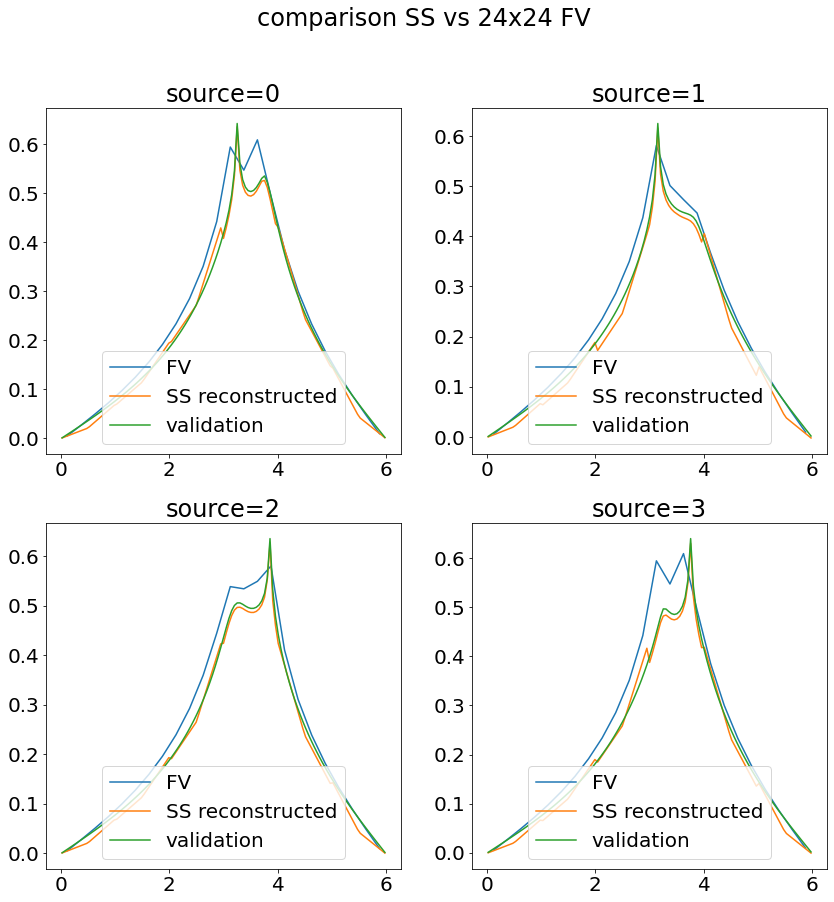

[70 62 66 72]


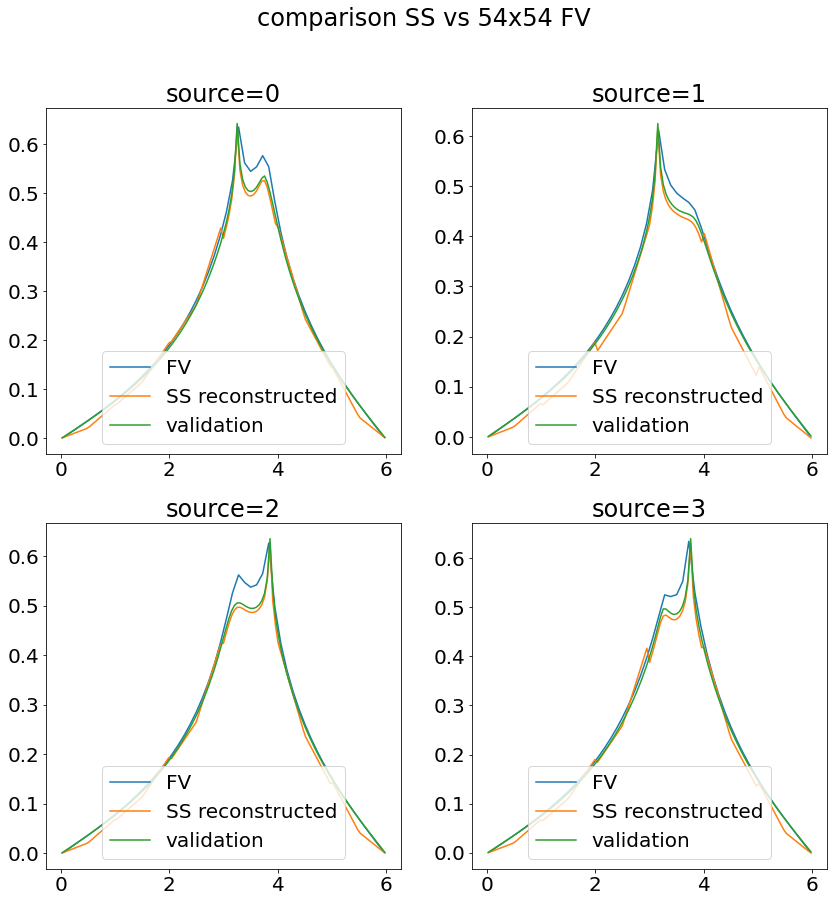

[70 62 66 72]


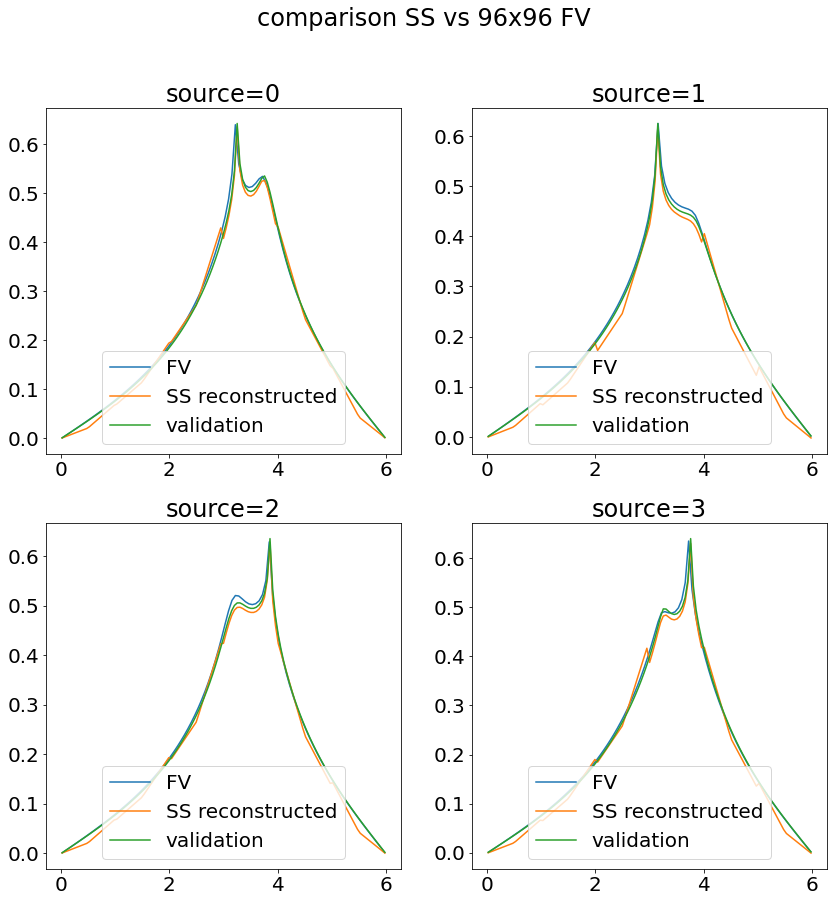

In [63]:
for a in np.arange(4):
    get_plots_comp(pos_s, solutions[a], rec, o, x_c[a], y_c[a], sol_val, y_v,x_v)

In [64]:
y_v


array([0.02521008, 0.07563025, 0.12605042, 0.17647059, 0.22689076,
       0.27731092, 0.32773109, 0.37815126, 0.42857143, 0.4789916 ,
       0.52941176, 0.57983193, 0.6302521 , 0.68067227, 0.73109244,
       0.78151261, 0.83193277, 0.88235294, 0.93277311, 0.98319328,
       1.03361345, 1.08403361, 1.13445378, 1.18487395, 1.23529412,
       1.28571429, 1.33613445, 1.38655462, 1.43697479, 1.48739496,
       1.53781513, 1.58823529, 1.63865546, 1.68907563, 1.7394958 ,
       1.78991597, 1.84033613, 1.8907563 , 1.94117647, 1.99159664,
       2.04201681, 2.09243697, 2.14285714, 2.19327731, 2.24369748,
       2.29411765, 2.34453782, 2.39495798, 2.44537815, 2.49579832,
       2.54621849, 2.59663866, 2.64705882, 2.69747899, 2.74789916,
       2.79831933, 2.8487395 , 2.89915966, 2.94957983, 3.        ,
       3.05042017, 3.10084034, 3.1512605 , 3.20168067, 3.25210084,
       3.30252101, 3.35294118, 3.40336134, 3.45378151, 3.50420168,
       3.55462185, 3.60504202, 3.65546218, 3.70588235, 3.75630

Text(0, 0.5, 'relative error')

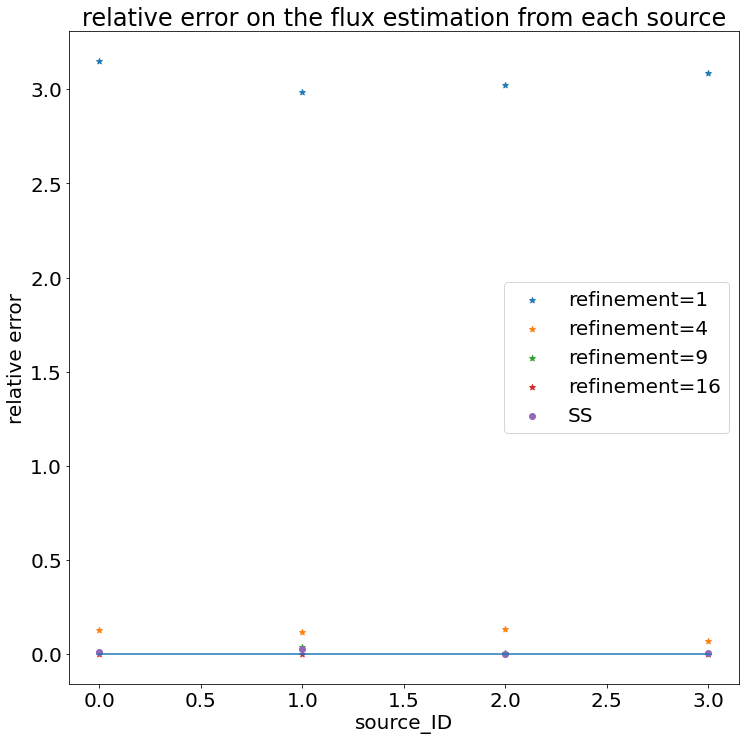

In [65]:
plt.rcParams["figure.figsize"] = (12,12)
for i in range(4):
    plt.scatter(np.arange(4),(q_comp[i]-q_array)/q_array, label="refinement={}".format((i+1)**2), marker='*')
plt.scatter(np.arange(4),(phi_q-q_array)/q_array, label="SS")
plt.plot(np.arange(4), np.zeros(4), marker="_")
plt.legend()
plt.title("relative error on the flux estimation from each source")
plt.xlabel("source_ID")
plt.ylabel("relative error")

In [66]:
post.manual_test_s_block_grads(t, phi,t.s_blocks[0])

The matrix calculated v_flux:  [ 0.01636072 -0.00182525  0.01787017 -0.00753322]
The manually calculated v_flux:  [ 0.01636072 -0.00182525  0.01787017 -0.00753322]
The matrix calculated G_flux:  [0.31843574 0.37819769 0.40163969 0.3906674 ]
The manually calculated G_flux:  [0.31843574 0.37819769 0.40163969 0.3906674 ]
The total calculated flux:  [0.33479646 0.37637244 0.41950986 0.38313418]
The total calculated flux:  [0.33479646 0.37637244 0.41950986 0.38313418]
div v 0.02487242194112671
total leaving flux 1.5138129390676969


array([-0.33479646, -0.37637244, -0.41950986, -0.38313418])

In [67]:
grads=post.reconstruction_gradients_manual(phi, t,get_boundary_vector(len(t.x), len(t.y)))
grads[t.s_blocks[0]]

array([-0.41145925, -0.34889837, -0.37812365, -0.35045924])

In [68]:
q_array

array([0.36016901, 0.37510198, 0.37131851, 0.36548916])

In [69]:
phi_q

array([0.36401439, 0.38455804, 0.37231736, 0.36805072])